In [1]:
# Useful imports
import matplotlib.pylab as plt
import numpy as np
import os
import sys
import pandas as pd

Took the following datasets:

| Data file | Termination |
| --- | --- |
| [GLSD020.CSV](data/long_coax_attempt2_fcngen33250a_20230613/GLSD020.CSV) | Direct into scope CH4, terminated into 50 Ohm with BNC tee. |
| [GLSD040.CSV](data/tdr_4mucryomanginintwp_open_floatingshield_fcngen33250a_20230620/GLSD040.CSV) | 3.639m shielded twisted pair from UCryo MDM100 cable, shield floating, open at end furthest from scope. |
| [GLSD041.CSV](data/tdr_4mucryomanginintwp_open_floatingshield_fcngen33250a_20230620/GLSD041.CSV) | 3.639m shielded twisted pair from UCryo MDM100 cable, shield connected, open at end furthest from scope. |
| [GLSD042.CSV](data/tdr_4mucryomanginintwp_open_floatingshield_fcngen33250a_20230620/GLSD042.CSV) | 3.639m shielded twisted pair from UCryo MDM100 cable, signal/return swapped shield floating, open at end furthest from scope. |

We'll use the SPICE PWL source to generate the measured function generator pulse.  First generate a PWL file from the dataset with the 50 Ohm termination instead of the cable.

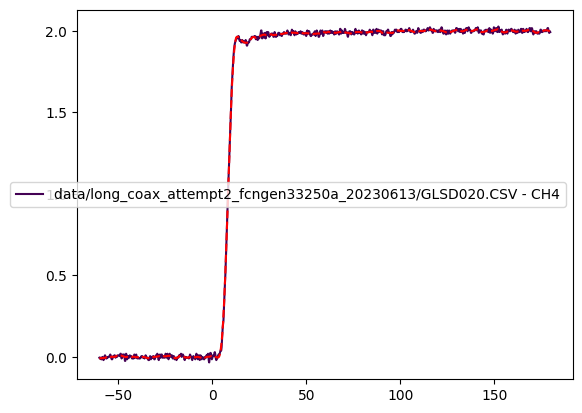

In [99]:
sys.argv[1]='data/long_coax_attempt2_fcngen33250a_20230613/GLSD020.CSV'; exec(open('make_pwl_file.py').read())

Copy [tdr_4ftucryomanginintwp_floatingshield_fcngen33250a.asc](tdr_4ftucryomanginintwp_floatingshield_fcngen33250a.asc) to [tdr_4mucryomanginintwp_open_shieldconnvsfloating_fcngen33250a.asc](tdr_4mucryomanginintwp_open_shieldconnvsfloating_fcngen33250a.asc).  Length of 143.25" = 3.639 meters.  Simulating this:

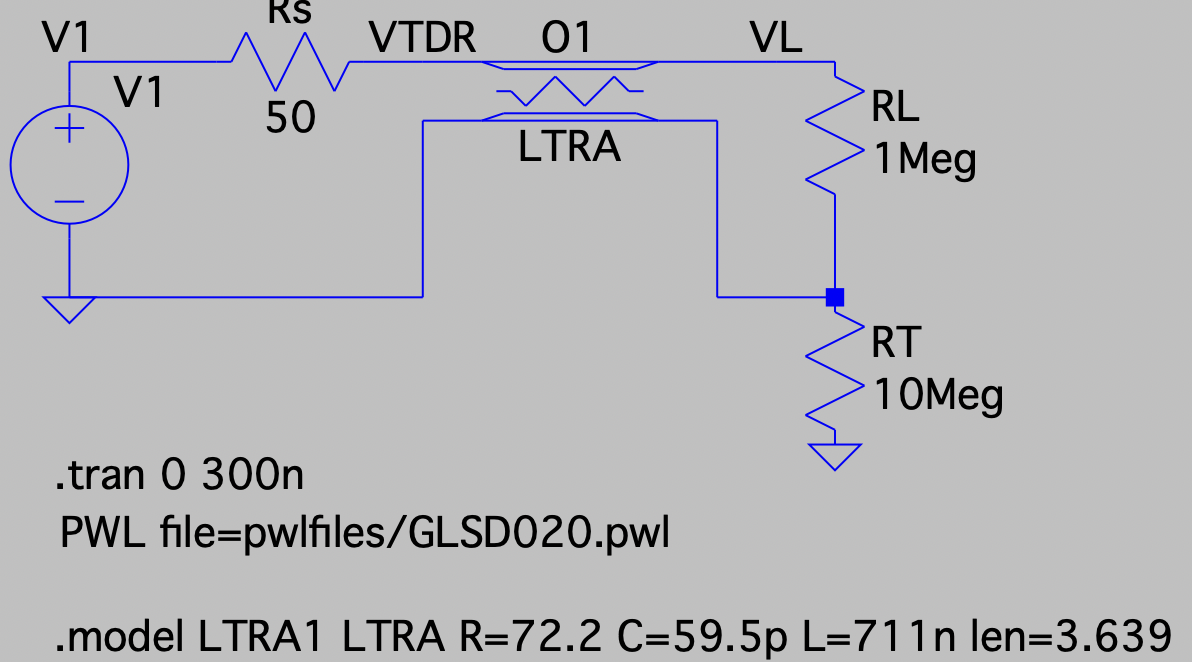

Compare to data

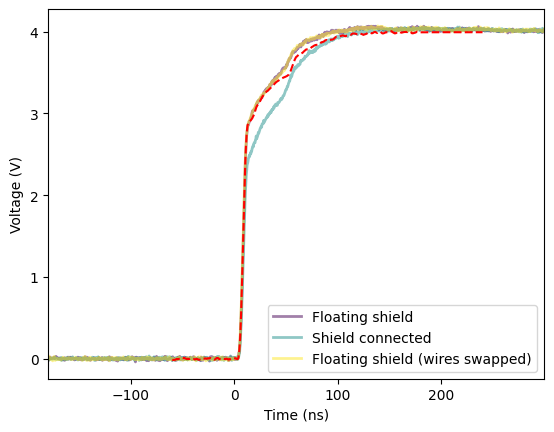

In [143]:
import ltspice

#
# Data
#
datafiles=['data/tdr_4mucryomanginintwp_open_floatingshield_fcngen33250a_20230620/GLSD040.CSV',
           'data/tdr_4mucryomanginintwp_open_floatingshield_fcngen33250a_20230620/GLSD041.CSV',
           'data/tdr_4mucryomanginintwp_open_floatingshield_fcngen33250a_20230620/GLSD042.CSV']

# LTSpice trans data starts at zero, so pull the start time from the first dataset and use to offset the model data.
# assumes datasets were all taken with the same time offset.
datalabels=['Floating shield','Shield connected','Floating shield (wires swapped)']
mint,maxt=None,None

# Pick a nice color map
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(datafiles))))

# Load datasets, and plot.  Also extract time offset for model.
for datalabel,datafile in zip(datalabels,datafiles):
    datadf=pd.read_csv(datafile, index_col=False)
    datadf=datadf.dropna(axis=1,how='all')
    
    t_ns=1.e9*datadf['in s'].values
    v4=datadf['C4 in V'].values
    v4=v4-np.mean(v4[:200]) # shifts starting voltage to zero to simplify plots
    plt.plot(t_ns,v4,label=f'{datalabel}',alpha=0.5,lw=2) # plot with some transparency so can overlay model
    if mint is None:
        mint=np.min(t_ns)
        maxt=np.max(t_ns)

#
# Overplot model.  LTSpice must be open and sim must have been run.
#
ascpath = 'tdr_4mucryomanginintwp_open_shieldconnvsfloating_fcngen33250a.raw'
l = ltspice.Ltspice(ascpath)
l.parse() # Data loading sequence. It may take few minutes for huge file.

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(datafiles))))

for i in range(l.case_count):
    time = l.get_time(i)    
    vtdr = l.get_data('V(vtdr)',i)
    plt.plot(mint+time*1.e9+120,2.0*vtdr,'r--') # 2x here because fcn gen outputs 2x the programmed signal in 50 Ohm mode

plt.xlabel('Time (ns)')
plt.xlim(mint,maxt)
plt.ylabel('Voltage (V)')

plt.legend()    
    
plt.xlabel('Time (ns)')
plt.xlim(mint,maxt)
#plt.xlim(0,100)
plt.ylabel('Voltage (V)')

plt.legend()

Fairly good agreement, but definitely not capturing everything.  The shield connected curve is interesting, and hard to understand - the cable delay seems unaffected.